# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [57]:
import dynamic_stock_model as dsm 
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [58]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 0.005

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(46)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(46)  # from 2015 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



## Initial parameters


[5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 5444.914285714285, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 47


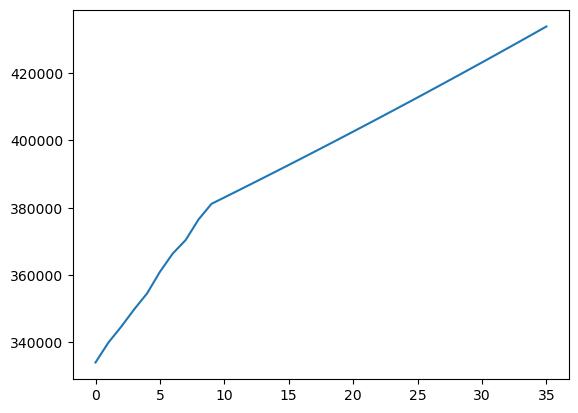

In [59]:
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/21]*21+[0]*26
print(GB_sales, len(GB_sales))

# Calculate housing increase over time for future years
Housing_past=[333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]#2015 to 2024
Housing_increase=[housing_2024*(1+housing_increase_2024)**i -housing_2024 for i in range(1,27)]
Housing_f=[housing_2024*(1+housing_increase_2024)**i for i in range(1,27)]
Housing=Housing_past+Housing_f
plt.plot(Housing)

## Create the models

output flow [0.00000000e+00 3.17925197e-01 9.84275910e-01 2.32614146e+00
 4.92237264e+00 9.74857959e+00 1.83683707e+01 3.31599913e+01
 5.75472509e+01 9.61784744e+01 1.54973711e+02 2.40949080e+02
 3.61739968e+02 5.24790611e+02 7.36255896e+02 9.99757867e+02
 1.31522700e+03 1.67810288e+03 2.07914275e+03 2.50498154e+03
 2.93942285e+03 3.36526164e+03 3.76598358e+03 4.12819311e+03
 4.44232038e+03 4.70322612e+03 4.90986520e+03 5.06429605e+03
 5.17029532e+03 5.23188343e+03 5.25204744e+03 5.23188343e+03
 5.17029532e+03 5.06429605e+03 4.90986520e+03 4.70322612e+03
 4.44232038e+03 4.12819311e+03 3.76598358e+03 3.36526164e+03
 2.93956858e+03 2.50519147e+03 2.07937984e+03 1.67835101e+03
 1.31547945e+03 1.00001193e+03 7.36510545e+02]
('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 47 years.<br>Inflow vector is present with 47 years.<br>Total stock is present with 47 years.<br>Stock by cohorts is present with 47 years and 47 cohorts.<br>Total outflow is present wi

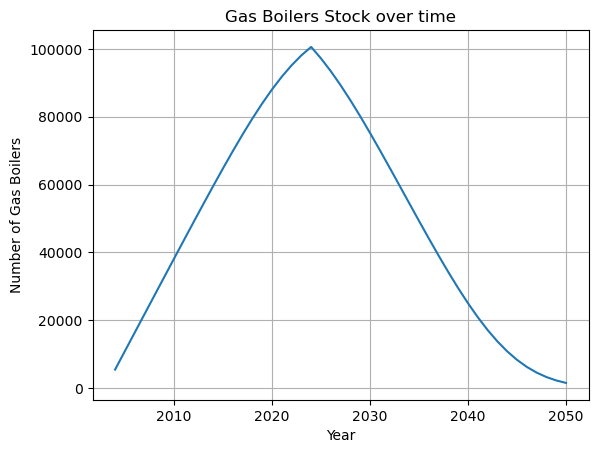

240.9490803029421


In [76]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
Years_GB=np.arange(2004,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)



# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()
check_GB=GB_DSM.dimension_check()
print("output flow", GB_DSM.o)

# plot stock
print(check_GB)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.show()
print(GB_DSM.o[11])


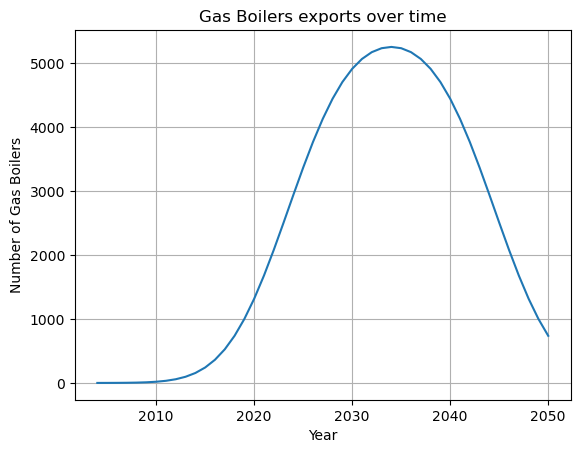

In [85]:
# plot stock

plt.grid()
plt.plot( GB_DSM.t,GB_DSM.o, label='Gas Boilers Stock')
plt.title('Gas Boilers exports over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.show()

In [ ]:
# Model for the heat pumps STOCK driven model
# past stock
HP_percent=[4.4/100, 5.1/100, 5.9/100, 6.8/100, 7.9/100, 9.2/100, 10.7/100, 12.4/100, 14.7/100, 16.7/100] # from 2015 to 2024
HP_stock_i =[x*h for x,h in zip(HP_percent,Housing_past)]  # from 2015 to 2024
print(HP_stock_i)
# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024) #63651



HP_stock_f = [a+b+(prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_DSM.o.tolist()[-(2050-2024):],Housing_increase[-(2050-2024):])]  #  2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f
print(len(HP_stock))

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = Years, 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

[14694.020000000002, 17333.982, 20332.993000000002, 23783.544, 28005.184, 33205.376, 39203.623, 45928.856, 55348.14599999999, 63651.047999999995]
3765.9835805636258
36


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is not present.<br>Outflow by cohorts is present with 36 years and 36 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)
67911.99803617307
63651.047999999995


Text(0, 0.5, '% of Heat pumps')

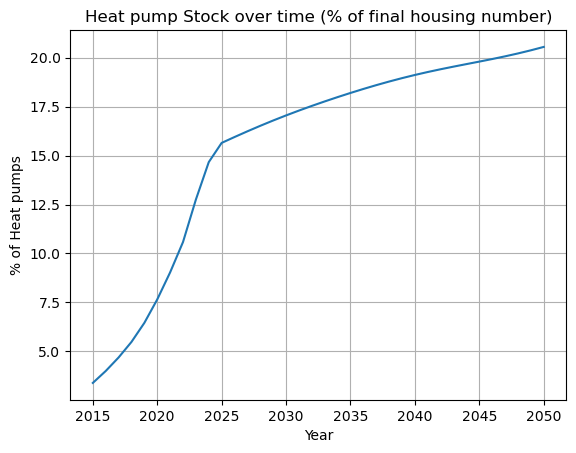

In [79]:
# compute stock driven model to get inflow
check_HP=HP_DSM.dimension_check()
print(check_HP)
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()

print(HP_DSM.s[10])
# plot stock
print(HP_DSM.s[9])
plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(housing_2024+Housing_increase[-1])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of final housing number)')
plt.xlabel('Year')
plt.ylabel('% of Heat pumps')

Text(0, 0.5, 'Heat pumps')

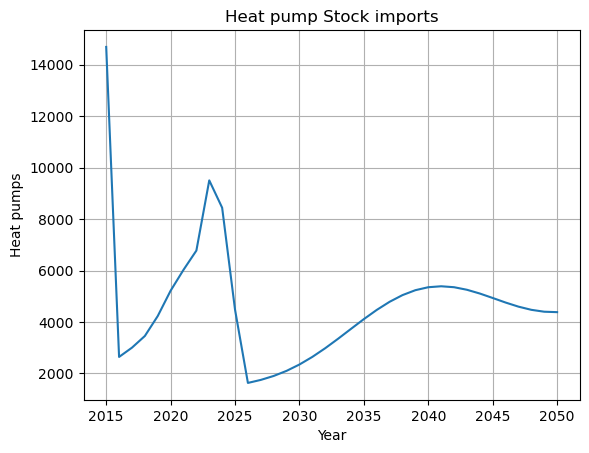

In [63]:
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')
plt.title('Heat pump Stock imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps')

## Calculating an incentive to buy HP 
Target of 55% in 2050(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

In [64]:
incentive_HP=1.5/100 #<- result: percentage of households that don't have converted yet but will convert due to incentives

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(incentive_HP*(Housing[26-i]-HP_stock[26-i]-Converted_households[-1])+Converted_households[-1])
print(Converted_households)
HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-(2050-2024):],Converted_households)]
print(len(HP_stock_f1))


[4762.3942799999995, 9638.43130362282, 14421.086781498961, 19112.65666760763, 23715.371195945605, 28231.370095271162, 32662.70029186919, 37011.33280407491, 41279.19224776438, 45468.1904164285, 49580.254840360394, 53617.344053050656, 57581.44347126698, 61474.539220670515, 65298.57157358262, 69055.37422664043, 72746.60944269823, 76417.80458105776, 80089.0853223419, 83754.72620250676, 87406.18596446916, 91010.93253500212, 94543.1307869771, 98014.60066517245, 101408.79176019486, 104725.88015379194]
26


In [65]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
print(HP_stock)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = Years, 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

[14694.020000000002, 17333.982, 20332.993000000002, 23783.544, 28005.184, 33205.376, 39203.623, 45928.856, 55348.14599999999, 63651.047999999995, 67911.99803617307, 69212.88682256358, 70479.76402818882, 71703.0823120455, 72877.72502145992, 74002.66975399913, 75079.99778902438, 76113.50872454447, 77107.24606096027, 78064.22004763756, 78985.55005718117, 79870.16344096624, 80715.0966747693, 81516.35298565644, 82270.17950657275, 82974.54169376015, 83630.50869106705, 84243.2438995572, 84822.3414167616, 85381.36692433592, 85936.63195967708, 86505.41069390641, 87103.94518180077, 87745.6347462997, 88439.75116698915, 89190.88163604116]


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 36 years.<br>Inflow vector is present with 36 years.<br>Total stock is present with 36 years.<br>Stock by cohorts is present with 36 years and 36 cohorts.<br>Total outflow is present with 36 years.<br>Outflow by cohorts is present with 36 years and 36 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% Heat pumps')

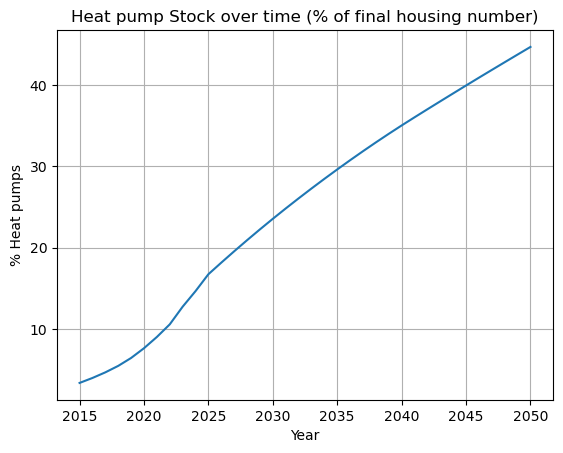

In [66]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
O_inc=HP_DSM_incentive.compute_outflow_total()
check_HP_inc=HP_DSM_incentive.dimension_check()
# plot stock
print(check_HP_inc)
plt.grid()
plt.plot( HP_DSM_incentive.t,np.array(HP_DSM_incentive.s)/(housing_2024+Housing_increase[-1])*100, label='Heat pump Stock')
plt.title('Heat pump Stock over time (% of final housing number)')
plt.xlabel('Year')
plt.ylabel('% Heat pumps')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [67]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² par an

# Heat pump
COP=3.26 # Coefficient of performance

# Gas boiler
LHV_gas= 50 # MJ/kg
efficiency_GB=0.9

# emissions
e_elec= 0.0273 #kgCO2/kWh
e_gas_boiler= 0.0754 #kgCO2/MJ  !!
e_HP_manufacture=1010+81-175 #kgCO2/unit (assembly+transport+End of Life)

# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg

## Electricity imports

In [68]:
# electricity needs per household

elec_need_HP= S_household*cons_surface/COP  #kWh/year

# electricity needs total per year
Elec_imports=np.array(HP_DSM.s)*elec_need_HP/1000000  #GWh/year
Elec_imports_inc=np.array(HP_DSM_incentive.s)*elec_need_HP/1000000  #GWh/year
print(Elec_imports)
print(Elec_imports_inc)

[12.84599908 15.15394132 17.77577609 20.79236209 24.48305963 29.02923975
 34.273106   40.15252748 48.38718285 55.64585485 59.37091853 60.5081986
 61.61574463 62.68521    63.71212157 64.69558552 65.63742138 66.54095088
 67.40970898 68.24632734 69.05178456 69.82514289 70.56381151 71.26429632
 71.92331644 72.5390932  73.11256128 73.6482347  74.15450093 74.64321955
 75.12865064 75.62589585 76.14915453 76.71014081 77.31696038 77.97362352]
[ 12.84599908  15.15394132  17.77577609  20.79236209  24.48305963
  29.02923975  34.273106    40.15252748  48.38718285  55.64585485
  63.53436138  68.93443456  74.22313644  79.39412764  84.44488473
  89.37638453  94.19223605  98.89748416 103.49734637 107.99612571
 112.39648588 116.69920134 120.903417   125.00737509 129.00949097
 132.90958907 136.71005726 140.4552111  144.17103258 147.86437589
 151.54203407 155.19066816 158.80189157 162.39775182 165.97188569
 169.52845739]


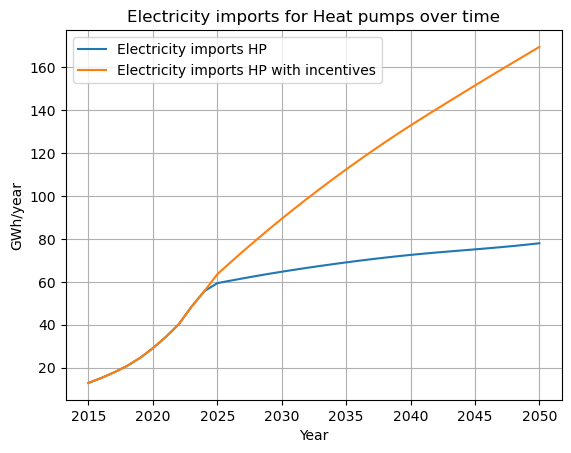

In [69]:
# plot electricity imports
plt.grid()
plt.plot( HP_DSM.t,Elec_imports, label='Electricity imports HP')
plt.plot( HP_DSM_incentive.t,Elec_imports_inc, label='Electricity imports HP with incentives')
plt.title('Electricity imports for Heat pumps over time')
plt.xlabel('Year')
plt.ylabel('GWh/year')
plt.legend()

## Gas imports

In [70]:
# Gas needs per household
gas_need_GB= S_household*cons_surface/(LHV_gas*1000*efficiency_GB)*3600  #kg/year

# gas needs total per year
Gas_imports=np.array(GB_DSM.s[20:])*gas_need_GB/1000000  #kt/year


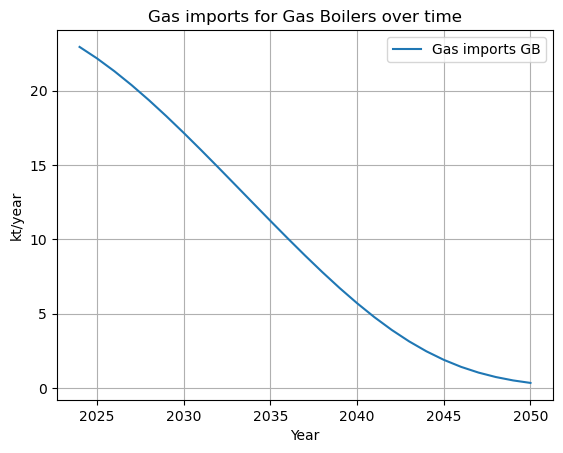

In [71]:
# plot gas imports
plt.grid()
plt.plot( GB_DSM.t[20:],Gas_imports, label='Gas imports GB')
plt.title('Gas imports for Gas Boilers over time')
plt.xlabel('Year')
plt.ylabel('kt/year')
plt.legend()

## $CO_2$ emissions
We use scope 3

In [72]:
# HP $CO_2$ emissions
CO2_emissions_HP= Elec_imports*1000*e_elec + HP_DSM.i*e_HP_manufacture #tCO2/year
CO2_emissions_HP_inc=Elec_imports_inc*1000*e_elec + HP_DSM_incentive.i*e_HP_manufacture #tCO2/year

# GB $CO_2$ emissions
CO2_emissions_GB= S_household*cons_surface*GB_DSM.s[20:]*e_gas_boiler*1000 #tCO2/year

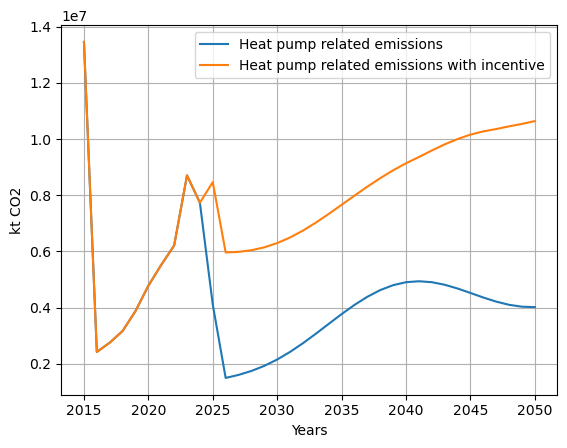

In [73]:
# Plot emissions per energy use per year
plt.grid()
#plt.plot(GB_DSM.t[20:], CO2_emissions_GB, label='Gas boiler related emissions')
plt.plot(HP_DSM.t, CO2_emissions_HP, label='Heat pump related emissions')
plt.plot(HP_DSM_incentive.t, CO2_emissions_HP_inc, label='Heat pump related emissions with incentive')
plt.xlabel('Years')
plt.ylabel('kt CO2')
plt.legend()

## Copper flows

In [74]:
# recycle coefficient
k=0.0

# Copper stocks
Copper_HP_s=np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_s=np.array(HP_DSM_incentive.s)*copper_HP
Copper_GB_s=np.array(GB_DSM.s)*copper_GB

# Copper exports
Copper_HP_o=(1-k)*np.array(HP_DSM.s)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_i=np.array(HP_DSM_incentive.i)*copper_HP-k*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_i=np.array(GB_DSM.i)*copper_GB-k*np.array(GB_DSM.o)*copper_GB


## Sensitivity analysis